In [5]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install transformers datasets
# Clean up the notebook
clean_notebook()


Notebook cleaned.


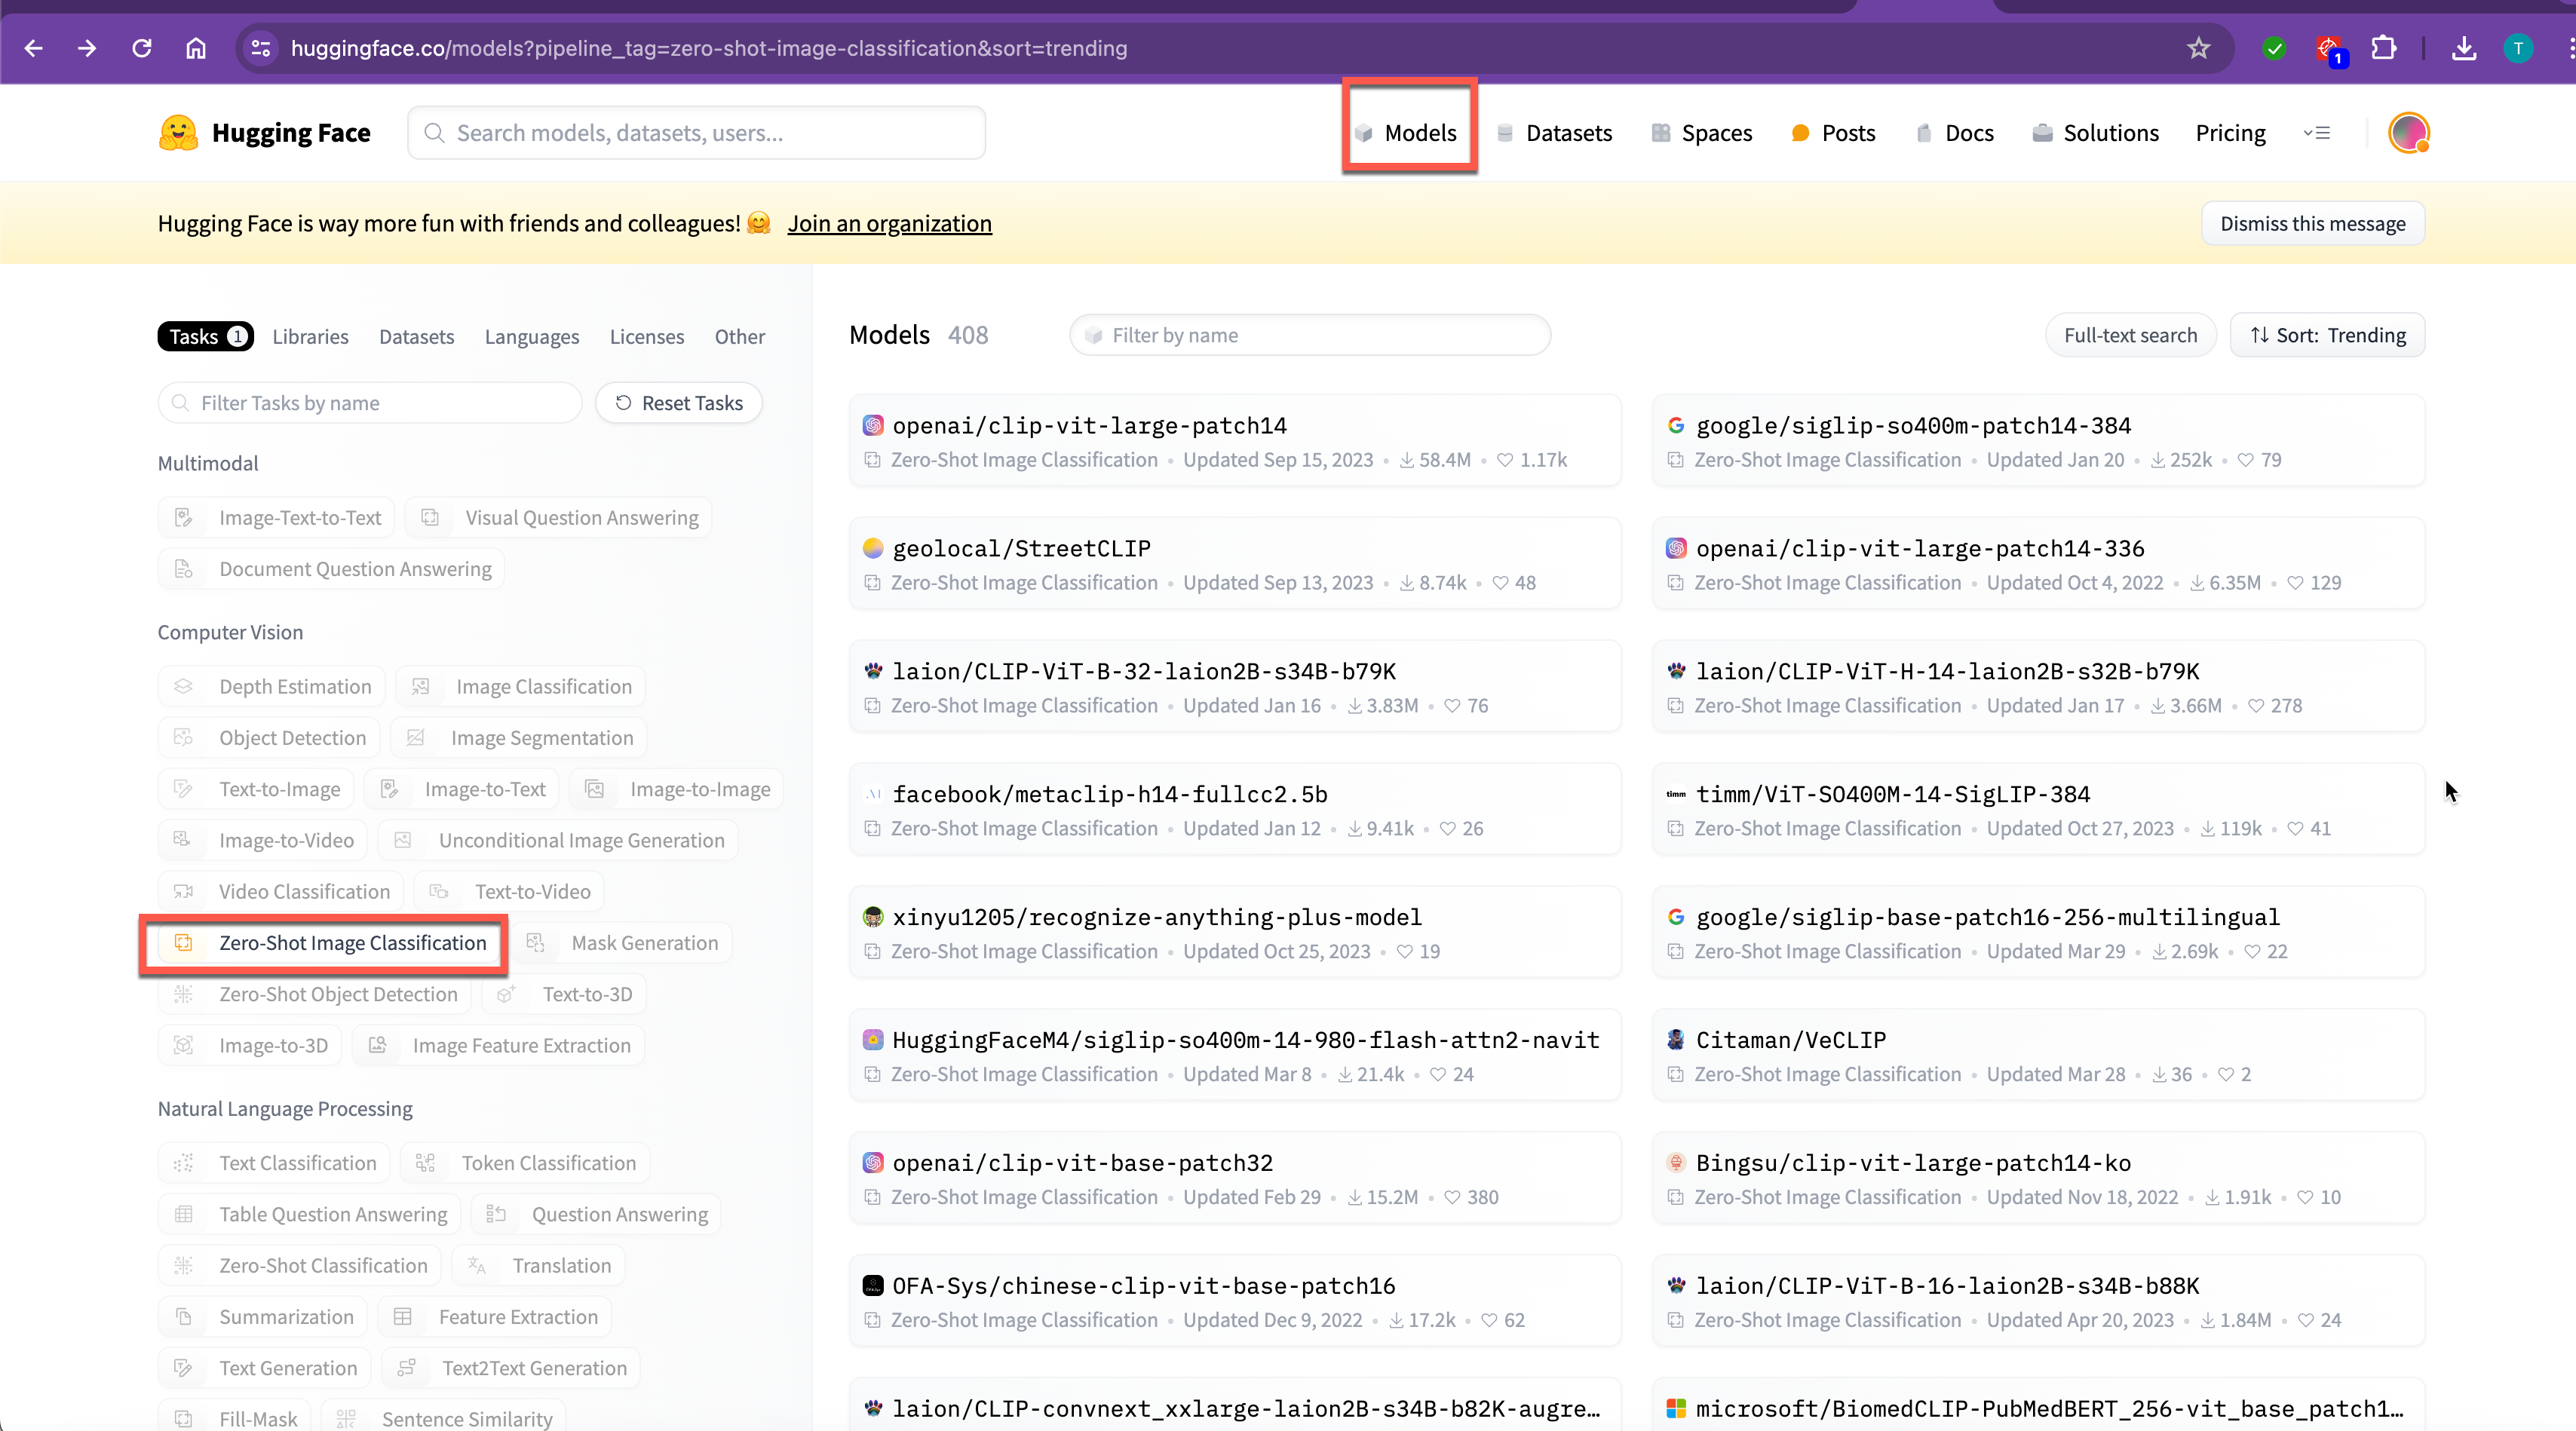

## Zero-shot image classification pipeline


https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=trending

The simplest way to try out inference with a model supporting zero-shot image classification is to use the corresponding [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline).
Instantiate a pipeline from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads):

In [1]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

detector

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Device set to use cuda:0


Next, choose an image you'd like to classify.

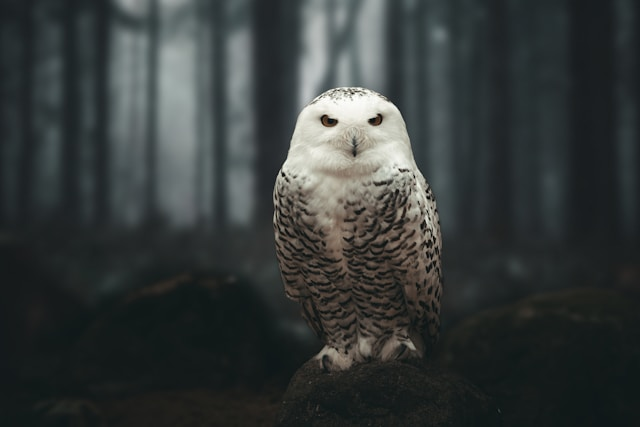

In [2]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

In [3]:
predictions = detector(image, candidate_labels=["fox", "bear", "seagull", "owl"])
predictions

[{'score': 0.9992450475692749, 'label': 'owl'},
 {'score': 0.0005944094737060368, 'label': 'seagull'},
 {'score': 8.649113442515954e-05, 'label': 'fox'},
 {'score': 7.409303361782804e-05, 'label': 'bear'}]

# Demo with dataset

https://huggingface.co/datasets/AI-Lab-Makerere/beans

{
  "angular_leaf_spot": 0,
  "bean_rust": 1,
  "healthy": 2,
}

In [5]:
from transformers import pipeline
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO

# Load the beans dataset
dataset = load_dataset("AI-Lab-Makerere/beans")

dataset

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [6]:
dataset['train'][0]

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

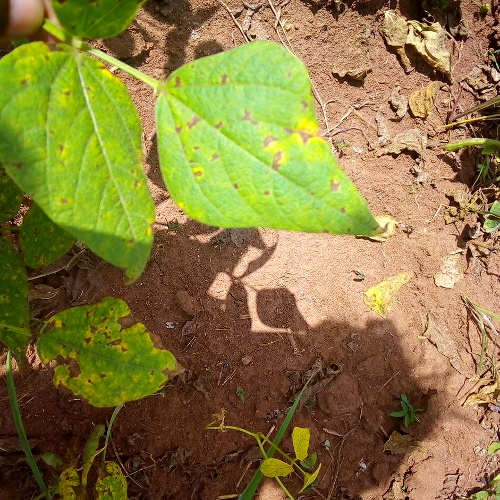

In [7]:
dataset['train'][0]['image']

{
  "angular_leaf_spot": 0,
  "bean_rust": 1,
  "healthy": 2,
}

labels  0 index = 1


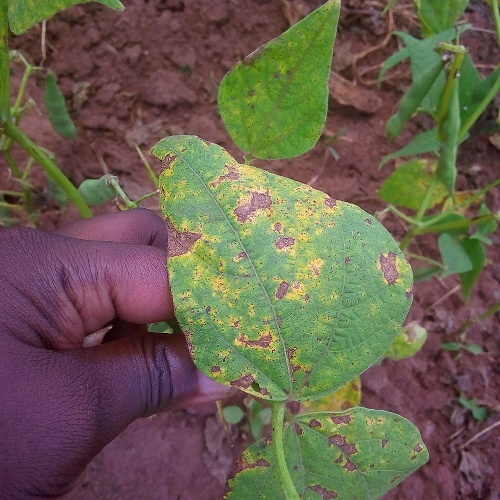

[{'score': 0.9974194765090942, 'label': 'angular_leaf_spot'},
 {'score': 0.0025771125219762325, 'label': 'bean_rust'},
 {'score': 3.491512870823499e-06, 'label': 'healthy'}]

In [8]:
import random
from IPython.display import display

# Define candidate labels
candidate_labels = ["healthy", "angular_leaf_spot", "bean_rust"]

# Get the number of samples in the dataset
num_samples = len(dataset)

# Generate a random index
random_index = random.randint(0, num_samples - 1)

# Get a sample image from the dataset
image = dataset['train'][random_index]['image']
label = dataset['train'][random_index]['labels']
print("labels ", label, "index =", random_index)

# Make predictions on the image
predictions = detector(image, candidate_labels=candidate_labels)

# Display the image
display(image)

# Display the predictions
predictions

## Zero-shot image classification by hand

Now that you've seen how to use the zero-shot image classification pipeline, let's take a look how you can run zero-shot
image classification manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads).
Here we'll use the same checkpoint as before:

In [9]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

checkpoint = "openai/clip-vit-large-patch14"
model      = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor  = AutoProcessor.from_pretrained(checkpoint)

Let's take a different image to switch things up.

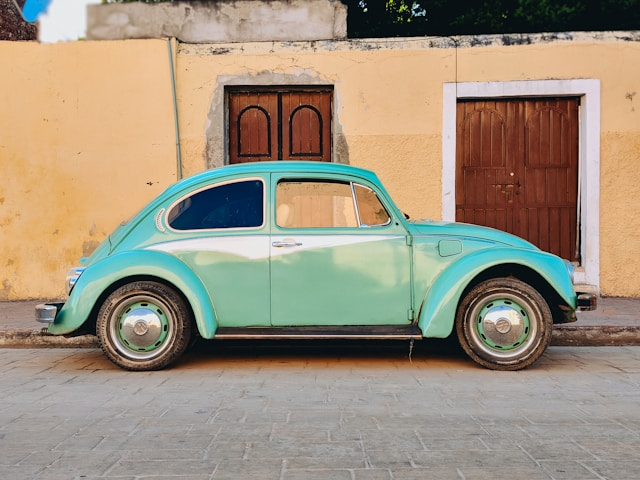

In [10]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg" alt="Photo of a car"/>
</div>

Use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the
image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [11]:
candidate_labels = ["tree", "car", "bike", "cat"]
inputs          = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

Pass the inputs through the model, and post-process the results:

In [12]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.9988661, 'label': 'car'},
 {'score': 0.0008380696, 'label': 'bike'},
 {'score': 0.0002645572, 'label': 'tree'},
 {'score': 3.1306623e-05, 'label': 'cat'}]